# 5.3 Using a pre-trained convnet

## A common and highly effective approach to deep learning on small image datasets is to use a pretrained network;

## A *pretrained network* is a saved network that was previously trained on a large dataset, typically on a large-scale image-classifiaction task.

## If the original dataset is large enough and general enough, then the spatial hierarchy of features learned by the pretrained network can effectively act as a generic model of the visual world, hence its features can prove useful for many different computer vision problems

## In this case, we consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes).  We use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014;

## There are two ways to use a pretrained network: *feature extraction* and *fine-tuning*

## 5.3.1 Feature extraction

### Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, whichi is trained from scratch.

### Convnets comprise 2 parts: *convolutional base* (convolution layers and pooling) & *densely connected* classifiers;
### Feature extraction consists of taking the convolutional base of a pre-trained network, running the new data through it and training a new classifier on top of the output. 

## WHY only reuse the convolutional base ? :
### Generally we should avoid reusing the densely connected classifier, the reason is that the representations learned by the convolutional base are more generic and therefore more reusable:
### the feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the problem settings, while the representations learned by the classifier will necessarily be specific to the set of classes on which the model was trained --- only contain information about the presence probability of specific class in the picture, which changes vitally on different settings;
### Additionally, the *locations* of the objects in the input image will not be learned by the densely connected layers: they get rid of the notion of space, whereas the object location is still described by convolutional feature maps. Thus for problems where object location matters, densely connected features are largely useless;

## How much should we reuse the model ?

### Note that the level of generality (and therefore reusability) of the representations extracted by specific convolutional layers depends on the *depth of layers* in the model:

### Layers come earlier in the model, extract local, highly generic feature maps (edges, colors, textures, etc.) whereas layers that are higher ip extract more abstracct concepts ('cat ear', 'dog ear', etc).

### So if the new dataset differs a lot from the dataset on which the original model was trained, you may be better  off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base

### In this case, because the ImageNet class contains multiple dog and cat classes, it's likely to be beneficial to reuse the information contained in the densely connected layers of the original network. BUT we choose not to, in order to cover the more general case when the class set of the new problem does not overlap the class set of the orginal model

### Let's put into practice by using the convolutonal base of the VGG16 network, which is pre-packaged in Keras. You can import from the *keras.applications* module. Here's a list of image-classification models (all pretrained on the ImageNet) that are available in Keras:

### 1) Xception
### 2) Inception V3
### 3) ResNet50
### 4) VGG16
### 5) VGG19
### 6) MobileNet

In [2]:
from keras.models import load_model

conv_base = load_model('conv_base.h5')

W0703 23:21:11.965164 140639730284288 deprecation_wrapper.py:119] From /usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0703 23:21:12.002148 140639730284288 deprecation_wrapper.py:119] From /usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0703 23:21:12.054224 140639730284288 deprecation_wrapper.py:119] From /usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0703 23:21:12.465032 140639730284288 deprecation_wrapper.py:119] From /usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_

In [1]:
# Instantiate the VGG16 convolutional base

from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (150, 150, 3))

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### *weights*: specifies the weight checkpoint from which to initialize the model;
### *include_top*: include or not the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet.
### *input_shape*: (optional) the shape of the image tensors that you'll feed into the network. If you don't pass it, the network still can process inputs of any size

### Let's see the architecture of the VGG16 convolutional base. It's similar to the simple convnets we're already familiar with

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### The final feature map has shape (4, 4, 512). That's the feature on top of which you'll stick a densely connected classifier.

### At this point, we could proceed in 2 ways:
### 1) Run the convolutional base over your dataset, recording its output to a Numpy array on disk, and then using this data as input to a stand-alone, densely connected classifier. 

### ----This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and by far th convolutional base is the most expensive part of the pipeline. But for the same reason, this technique will not allow you to use data augmentation

### 2) Extend the model (conv_base) by adding Dense layers on top, and run the whole thing end to end on the input data. This will allow you to use data augmentation, but it will be far more expensive than 1st method;

## M1:   Fast feature extraction without data augmentation

### Use *ImageDataGenerator* to extract images as Numpy arrays as well as their labels. You'll extract features from these images by calling the *predict* method of the conv_base model

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [5]:
base_dir = '/input/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count, 4, 4, 512))
    labels = np.zeros(shape = (sample_count))
    generator = datagen.flow_from_directory(
        directory, 
        target_size = (150, 150), 
        batch_size = batch_size, 
        class_mode = 'binary')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    
    return features, labels

In [6]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### The extracted features are currently of shape (samples, 4, 4, 512).  You will feed them into a densely connected classifier, so we first must flatten them to (samples, 8192):

In [7]:
import numpy as np

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 *512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

### Now we can define our densely connected classifier (note the use of dropout for regularization) and train it on the data and labels that you just recorded.

In [8]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = optimizers.RMSprop(lr = 2e-5),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

W0703 23:27:46.364267 140639730284288 deprecation.py:506] From /usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0703 23:27:46.444675 140639730284288 deprecation_wrapper.py:119] From /usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0703 23:27:46.466003 140639730284288 deprecation.py:323] From /usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the 

In [9]:
history = model.fit(train_features, train_labels,
                    epochs = 30, 
                    batch_size = 20,
                    validation_data = (validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.6092 - acc: 0.6695 - val_loss: 0.4641 - val_acc: 0.7960
Epoch 2/30
2000/2000 [==============================] - 1s 516us/step - loss: 0.4419 - acc: 0.8035 - val_loss: 0.3688 - val_acc: 0.8610
Epoch 3/30
2000/2000 [==============================] - 1s 487us/step - loss: 0.3609 - acc: 0.8430 - val_loss: 0.3260 - val_acc: 0.8700
Epoch 4/30
2000/2000 [==============================] - 1s 491us/step - loss: 0.3152 - acc: 0.8730 - val_loss: 0.3007 - val_acc: 0.8810
Epoch 5/30
2000/2000 [==============================] - 1s 507us/step - loss: 0.2958 - acc: 0.8795 - val_loss: 0.2858 - val_acc: 0.8820
Epoch 6/30
2000/2000 [==============================] - 1s 517us/step - loss: 0.2724 - acc: 0.8955 - val_loss: 0.2923 - val_acc: 0.8790
Epoch 7/30
2000/2000 [==============================] - 1s 481us/step - loss: 0.2590 - acc: 0.9025 - val_loss: 0.2655 - val_acc: 0.8850
Ep

### Let's look at loss and accuracy curves duuring training

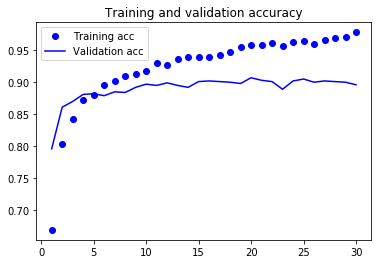

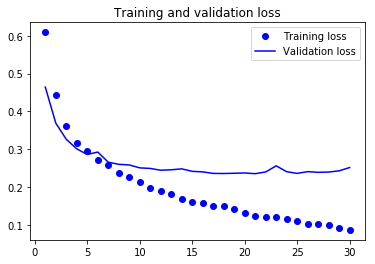

In [11]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### We reach a validation accuracy of about 90% --- much better than we achieved with the small model trained from scratch. But the plots also indicate that you're overfitting almost from the start --- despite using a dropout with a fairly large rate. 

### This is because this technique doesn't allow data augmentation, which is essential for preventing overfitting with small image datasets

## M2:  Feature extraction with data augemntation

### Extend the conv_base model and run it end to end on the inputs. Because models behave just like layers, you can add a model (like conv_base)  to a Sequential model just like before adding a layer

In [12]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


### As you can see, the convolutional base of VGG16 has 14, 714, 688 parameters, which is very large. The classifier you are adding on top has 2 million parameters

### Before we compile and train the model, it's very important to freeze the convolutional base.
### *Freezing* a layer means preventing their weights from being updated during training. If you don't do this, then the representations that were previously learned by the convolutional base will be modified during training. Because the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In [14]:
# In Keras, we freeze a networkk by setting *trainable* attribute to False

print('This is the number of trainable weights before freezing the conv_base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable weights after freezing the conv_base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv_base: 30
This is the number of trainable weights after freezing the conv_base: 4


### With this setup, only the weights from the two Dense layers that you added will be trained: That's a total of 4 weight tensors: two per layer (weight matrix and bias vector).

### Note that in order for these changes to take effect, you must first compile the model. If you ever modify the trainability after compilation, then you should re-compile it, otherwise these changes will be ignored.

### Now we can use the same data augmentation technique as before:

In [15]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

test_datagen = ImageDataGenerator(rescale = 1./255) # note validaiton data cannot be augmented !!!

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150), 
    batch_size = 20, 
    class_mode = 'binary')

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(lr = 2e-5),
              metrics = ['acc'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [16]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = 30,
    validation_data = validation_generator,
    validation_steps = 50)

Epoch 1/30
100/100 [==============================] - 39s 388ms/step - loss: 0.5885 - acc: 0.6880 - val_loss: 0.4450 - val_acc: 0.8330
Epoch 2/30
100/100 [==============================] - 35s 347ms/step - loss: 0.4786 - acc: 0.7875 - val_loss: 0.3756 - val_acc: 0.8500
Epoch 3/30
100/100 [==============================] - 34s 342ms/step - loss: 0.4296 - acc: 0.8055 - val_loss: 0.3279 - val_acc: 0.8720
Epoch 4/30
100/100 [==============================] - 35s 353ms/step - loss: 0.4067 - acc: 0.8220 - val_loss: 0.3091 - val_acc: 0.8700
Epoch 5/30
100/100 [==============================] - 35s 352ms/step - loss: 0.3868 - acc: 0.8280 - val_loss: 0.2956 - val_acc: 0.8780
Epoch 6/30
100/100 [==============================] - 35s 347ms/step - loss: 0.3596 - acc: 0.8395 - val_loss: 0.2839 - val_acc: 0.8870
Epoch 7/30
100/100 [==============================] - 35s 351ms/step - loss: 0.3585 - acc: 0.8405 - val_loss: 0.2771 - val_acc: 0.8870
Epoch 8/30
100/100 [==============================] - 3

### Let's plot the results again,  as you can see we reach a validation accuracy of about 96%, much better than achieved with the small convnet trained from scratch and no obvious overfitting problem.

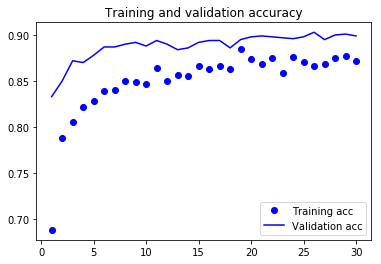

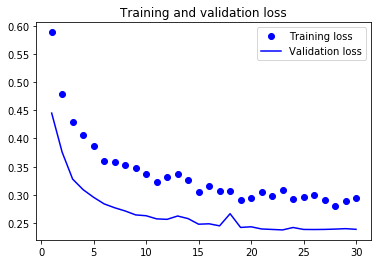

In [17]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 5.3.2 Fine-tuning (模型微调)

### Fine-tuning consists of unfreezing a few of the *top* layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the Dense layers)

### This is called *fine-tuning* because it slightly adjusts the more *abstract*  representations of the model being reused, in order to make them more relevant for the problem at hand.

### We earlier said it's necessary to freeze the convolutional base of VGG16 in order to be able to train a randomly initialized classifier on top. For the same reason, it's only possible to fine-tune the top layers of the convolutional base once the classifier on top has ALREADY been trained.

### If the classifier isn't alreadyt trained, then the error signal propagating through the network during training will be too large, and the representations previously learned by the layers being fine-tuned will be destroyed. Thus the steps for fine-tuning a network are as follows:

### 1) Add your custom network on top of an already-trained base network;
### 2) Freeze the base network;
### 3) Train the part you added;
### 4) Unfreeze some layers in the base network;
### 5) Jointly train both these layers and the part you added.

### We have finished the first 3 steps when doing feature extraction. Let;s proceed with step 4: unfreeze the conv_base and then freeze individual layers inside it.

### As a reminder, this is what the convolutional base looks like:

In [18]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### We fine-tune the last three convolutional layers: block5_conv1, block5_conv2 & block5_conv3 should be trainable.
## WHY not fine-tune more layers ? WHY not fine-tune the whole convolutional base ? 
### Of course, you could. But you need to consider the following:
### 1) Earlier layers in the conv_base encode more generic, reusable featrues, whereas layers higher up encode more specialized features. It's more useful to fine-tune the more specialized features, because these are the ones that need to be repurposed on the new problem;

### 2) The more parameters you are training, the more you are at risk of overfitting

### Thus it's a good strategy to fine-tune only the top two or three layers in the conv_base. Let's see this up, strarting from where you left off in the previous example

In [19]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':  # after loop to block5_conv1, the set_trainable will always be True
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

### Now we can begin fine-tune the network. You'll do this with the RMSprop optimizer, using a very low learning rate. The reason for using a low learning rate is that you want to limit the magnitude of the modifications you make to the representations of the three layers you're fine-tuning. Updates that are too large may harm these representations

In [20]:
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(lr = 1e-5),
              metrics = ['acc'])

In [21]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = 30,
    validation_data = validation_generator,
    validation_steps = 50)

Epoch 1/30
100/100 [==============================] - 40s 396ms/step - loss: 0.3041 - acc: 0.8625 - val_loss: 0.2982 - val_acc: 0.8840
Epoch 2/30
100/100 [==============================] - 35s 354ms/step - loss: 0.2525 - acc: 0.8925 - val_loss: 0.2334 - val_acc: 0.9100
Epoch 3/30
100/100 [==============================] - 35s 352ms/step - loss: 0.2287 - acc: 0.9105 - val_loss: 0.1966 - val_acc: 0.9170
Epoch 4/30
100/100 [==============================] - 36s 359ms/step - loss: 0.2165 - acc: 0.9125 - val_loss: 0.2056 - val_acc: 0.9140
Epoch 5/30
100/100 [==============================] - 35s 348ms/step - loss: 0.2076 - acc: 0.9155 - val_loss: 0.1971 - val_acc: 0.9240
Epoch 6/30
100/100 [==============================] - 36s 357ms/step - loss: 0.1872 - acc: 0.9275 - val_loss: 0.1927 - val_acc: 0.9320
Epoch 7/30
100/100 [==============================] - 36s 355ms/step - loss: 0.1812 - acc: 0.9255 - val_loss: 0.1841 - val_acc: 0.9280
Epoch 8/30
100/100 [==============================] - 3

### Let's plot the results as before

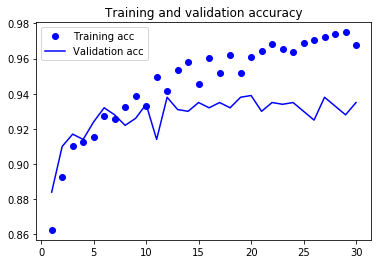

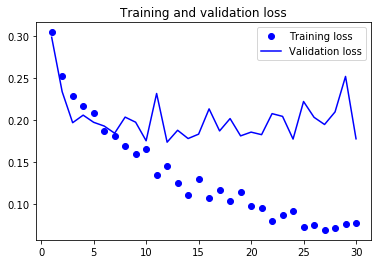

In [22]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### The curves look noisy, you can smooth them by replacing  every loss and accuracy with exponential moving averages of these quantities. Here's a trivial utility function to do this:

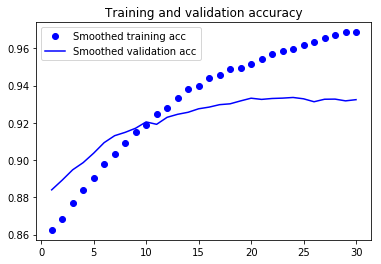

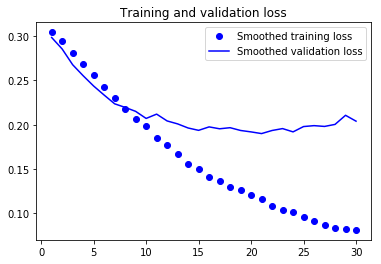

In [23]:
def smooth_curve(points, factor = 0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### The validation accuracy curve looks much cleaner. You see a nice 1% absolute improvement in accuracy, from about 96% to 97%
### Note that the loss curve doesn't show any real improvement (in fact, it's deteriorating). That's because what you display is an average of pointwise loss values, but what matters for accurcay is the distribution of loss values, not their average. The model may still be improving even if this isn't reflected in the average loss.

### Now we can finally evaluate this model on the test data:

In [24]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps = 50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9419999921321869


### Here you get a test accuracy of 97%, which would be one of the top results in the original Kaggle competition, but we managed to reach it using only a small fraction of the training data available (about 10%)